## Hybrid method: Recursive feature addition

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Read Data

In [41]:
data = pd.read_csv('../DoHBrwTest.csv')
data.shape

(53860, 35)

In [42]:
data.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,is_intrusion
0,7.0,2.0,52742,443,18355.0,0.046455,55,1183.941449,66,1420.729738,...,1.000000,0.000000,0.000000,0.046455,0.046455,0.046455,-10.000000,-10.000000,0.000000,0
1,7.0,2.0,54640,443,18365.0,96.750105,42044,434.562836,44920,464.288902,...,0.561877,0.001700,0.041234,0.033549,0.026931,0.026952,0.481463,0.159978,1.229096,0
2,7.0,2.0,56611,443,18373.0,96.365606,41539,431.056284,44577,462.582054,...,0.549156,0.000956,0.030926,0.026551,0.026848,0.026879,-0.028834,-0.010614,1.164778,0
3,7.0,2.0,56611,443,18374.0,121.356820,60659,499.840058,67897,559.482360,...,0.556570,0.001013,0.031829,0.027571,0.026862,0.026941,0.066819,0.019791,1.154439,0
4,7.0,2.0,56611,443,18375.0,104.669253,30409,290.524668,30718,293.476825,...,0.331633,0.001226,0.035013,0.029797,0.026867,0.026908,0.251063,0.082517,1.175049,0


### Train - Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.35,
    random_state=0)

X_train.shape, X_test.shape

((35009, 34), (18851, 34))

### Remove constant and quasi-constant features

In [44]:
# to speed things up we remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float64(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.89:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35009, 33), (18851, 33))

### Remove duplicated

In [45]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30


0

In [46]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35009, 33), (18851, 33))

### Train a ML model with all features

In [47]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)
model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=1.000000


### Rank features by importance

Text(0.5, 0, 'Feature')

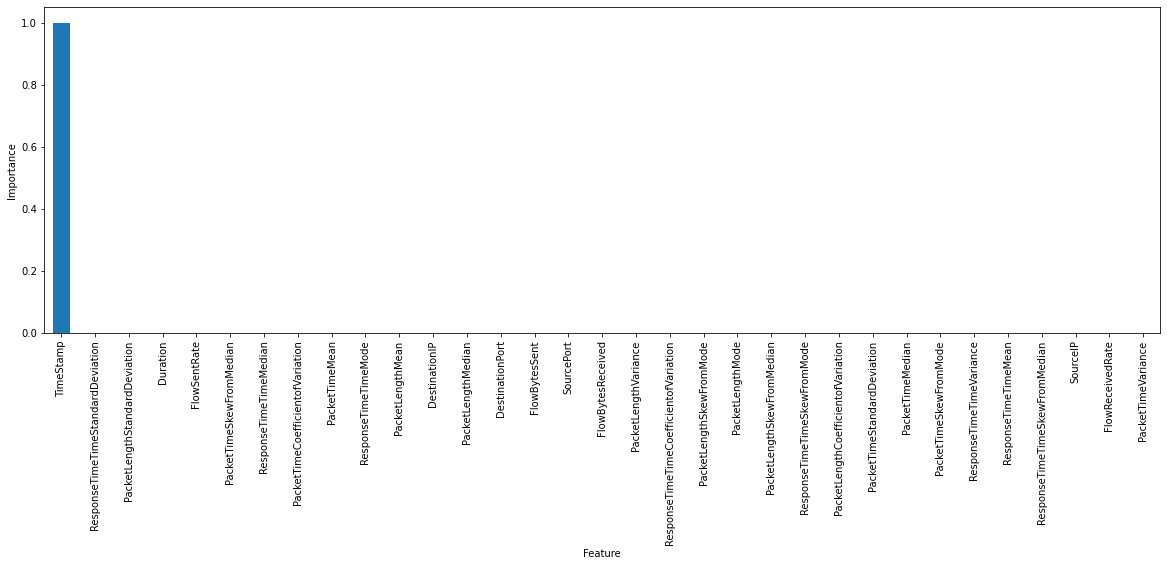

In [48]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.ylabel('Importance')
plt.xlabel('Feature')

In [49]:
# make list of ordered features
features = list(features.index)
features

['TimeStamp',
 'ResponseTimeTimeStandardDeviation',
 'PacketLengthStandardDeviation',
 'Duration',
 'FlowSentRate',
 'PacketTimeSkewFromMedian',
 'ResponseTimeTimeMedian',
 'PacketTimeCoefficientofVariation',
 'PacketTimeMean',
 'ResponseTimeTimeMode',
 'PacketLengthMean',
 'DestinationIP',
 'PacketLengthMedian',
 'DestinationPort',
 'FlowBytesSent',
 'SourcePort',
 'FlowBytesReceived',
 'PacketLengthVariance',
 'ResponseTimeTimeCoefficientofVariation',
 'PacketLengthSkewFromMode',
 'PacketLengthMode',
 'PacketLengthSkewFromMedian',
 'ResponseTimeTimeSkewFromMode',
 'PacketLengthCoefficientofVariation',
 'PacketTimeStandardDeviation',
 'PacketTimeMedian',
 'PacketTimeSkewFromMode',
 'ResponseTimeTimeVariance',
 'ResponseTimeTimeMean',
 'ResponseTimeTimeSkewFromMedian',
 'SourceIP',
 'FlowReceivedRate',
 'PacketTimeVariance']

### Build a ML model with 1 feature

In [50]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# build initial model using all the features
model_one_feature = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print('Test one feature xgb ROC AUC=%f' % (roc_first))

Test one feature xgb ROC AUC=1.000000


### Select features

In [60]:
# first we arbitrarily set the increase in roc-auc if the increase is above this threshold,
# the feature will be kept
from sklearn import svm

tol = 0.0005

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = svm.NuSVC(kernel='rbf', nu=0.1, gamma='scale', random_state=None, probability=True)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with one feature
    print('Previous round Test ROC AUC={}'.format((roc_first)))

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        roc_first = roc_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print

# now the loop is finished, we evaluated all the features
print('Done!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  ResponseTimeTimeStandardDeviation 1  out of  33
New Test ROC AUC=1.0
Previous round Test ROC AUC=1.0
Increase in ROC AUC=0.0
remove:  ResponseTimeTimeStandardDeviation

testing feature:  PacketLengthStandardDeviation 2  out of  33
New Test ROC AUC=1.0
Previous round Test ROC AUC=1.0
Increase in ROC AUC=0.0
remove:  PacketLengthStandardDeviation

testing feature:  Duration 3  out of  33
New Test ROC AUC=1.0
Previous round Test ROC AUC=1.0
Increase in ROC AUC=0.0
remove:  Duration

testing feature:  FlowSentRate 4  out of  33
New Test ROC AUC=0.9999942653557683
Previous round Test ROC AUC=1.0
Increase in ROC AUC=-5.734644231703001e-06
remove:  FlowSentRate

testing feature:  PacketTimeSkewFromMedian 5  out of  33
New Test ROC AUC=1.0
Previous round Test ROC AUC=1.0
Increase in ROC AUC=0.0
remove:  PacketTimeSkewFromMedian

testing feature:  ResponseTimeTimeMedian 6  out of  33
New Test ROC AUC=1.0
Previous round Test ROC AUC=1.0
Increas

In [61]:
features_to_keep

['TimeStamp']

In [14]:
# build initial model
model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=1.000000


Gradient Boosting model built with 8 features shows a similar performance than the one built the full dataset.

In [15]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [16]:
X_train.shape, X_test.shape

((35009, 1), (18851, 1))

## Standardize Data





In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers





In [18]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation





In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression





In [20]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1).fit(X_train, y_train)

CPU times: user 67.4 ms, sys: 173 ms, total: 240 ms
Wall time: 1.56 s


In [21]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.8352847787259376
F1 Score: 0.8363435602176827
FPR: 0.22624870312731585
TPR: 0.906247329288095


### Naive Bayes





In [23]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-09).fit(X_train, y_train)

CPU times: user 20.9 ms, sys: 6.19 ms, total: 27 ms
Wall time: 25.3 ms


In [24]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.37090692597737646
F1 Score: 0.5220721264021227
FPR: 0.9490143767600415
TPR: 0.7398512947611315


### Random Forest





In [25]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 4.12 s, sys: 60.9 ms, total: 4.18 s
Wall time: 4.18 s


In [26]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5303433220877158
F1 Score: 0.38114422156955313
FPR: 0.020601748925448346
TPR: 0.01247756601999829


### KNN




In [27]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance').fit(X_train, y_train)

CPU times: user 6.44 ms, sys: 1.65 ms, total: 8.09 ms
Wall time: 6.19 ms


In [28]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.31081563802341733
f1: 0.43517012556112156
fpr: 0.9153697939825107
tpr: 0.5716605418340313


### CatBoost




In [29]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6571545	total: 62.4ms	remaining: 3.06s
1:	learn: 0.6234742	total: 70.3ms	remaining: 1.69s
2:	learn: 0.5930098	total: 78.8ms	remaining: 1.23s
3:	learn: 0.5647872	total: 86.1ms	remaining: 990ms
4:	learn: 0.5379403	total: 93ms	remaining: 837ms
5:	learn: 0.5125891	total: 100ms	remaining: 733ms
6:	learn: 0.4889041	total: 107ms	remaining: 659ms
7:	learn: 0.4664049	total: 114ms	remaining: 597ms
8:	learn: 0.4459411	total: 121ms	remaining: 552ms
9:	learn: 0.4265493	total: 128ms	remaining: 514ms
10:	learn: 0.4082722	total: 135ms	remaining: 480ms
11:	learn: 0.3910875	total: 142ms	remaining: 451ms
12:	learn: 0.3747257	total: 149ms	remaining: 424ms
13:	learn: 0.3592513	total: 156ms	remaining: 402ms
14:	learn: 0.3444096	total: 163ms	remaining: 380ms
15:	learn: 0.3305746	total: 171ms	remaining: 364ms
16:	learn: 0.3170544	total: 178ms	remaining: 345ms
17:	learn: 0.3047341	total: 185ms	remaining: 329ms
18:	learn: 0.2925291	total: 192ms	remaining: 313ms
19:	learn: 0.2813931	total: 198ms	rema

In [30]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5368922405239135
F1 Score: 0.39322502459172953
FPR: 0.018452645620275678
TPR: 0.024100504230407657


## Model Evaluation





In [31]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../KDDTest.csv")
test_df.shape

(22543, 42)

In [32]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion'])

In [33]:
X_eval = X_eval[features_to_keep]

In [34]:
X_eval.shape

(22543, 8)

### Model Evaluation - Logistic Regression





In [35]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1, random_state=42)

In [36]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [37]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.9126090278535777
Testing accuracy is  0.8352847787259376


In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.8352847787259376
F1 Score: 0.8363435602176827
Precision Score: 0.7764516365233946
Recall Score: 0.906247329288095
Confusion Matrix:
 [[10441  3053]
 [ 1097 10604]]


### Cross validation - Logistic Regression





In [39]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.82025 (+/- 0.05253)
F1 Score: 0.83009 (+/- 0.05509)
Precision: 0.89582 (+/- 0.02851)
Recall: 0.77392 (+/- 0.07898)


### Model Evaluation - Naive Bayes





In [40]:
modelNB = GaussianNB(var_smoothing=1e-09)
modelNB.fit(X_train, y_train)

GaussianNB()

In [41]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [42]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.7048235212399655
Testing accuracy is  0.37090692597737646


In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))



Performance measures for test:
--------
Accuracy: 0.37090692597737646
F1 Score: 0.5220721264021227
Precision Score: 0.40334529189768437
Recall Score: 0.7398512947611315
Confusion Matrix:
 [[  688 12806]
 [ 3044  8657]]


### Cross validation - Naive Bayes





In [44]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.75496 (+/- 0.02430)
F1 Score: 0.75969 (+/- 0.03172)
Precision: 0.85932 (+/- 0.02879)
Recall: 0.68158 (+/- 0.05788)


### Model Evaluation - Random Forest




In [45]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [46]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [47]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  0.9996725443305516
Testing accuracy is  0.5303433220877158


In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.5303433220877158
F1 Score: 0.38114422156955313
Precision Score: 0.4456651210197384
Recall Score: 0.5303433220877158
Confusion Matrix:
 [[13216   278]
 [11555   146]]


### Cross validation - Random Forest





In [49]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.98217 (+/- 0.00599)
F1 Score: 0.98434 (+/- 0.00523)
Precision: 0.98405 (+/- 0.00839)
Recall: 0.98465 (+/- 0.00596)


### Model Evaluation - KNN





In [50]:
modelKNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=1, n_neighbors=2,
                     weights='distance')

In [51]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [52]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9994244718536968
Testing accuracy is  0.31081563802341733


In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.31081563802341733
F1 Score: 0.43517012556112156
Precision Score: 0.3512945748647655
Recall Score: 0.5716605418340313
Confusion Matrix:
 [[ 1142 12352]
 [ 5012  6689]]


### Cross validation - KNN




In [54]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.96992 (+/- 0.00793)
F1 Score: 0.97356 (+/- 0.00691)
Precision: 0.97471 (+/- 0.01003)
Recall: 0.97241 (+/- 0.00554)


### Model Evaluation - CatBoost




In [55]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6571545	total: 7.29ms	remaining: 357ms
1:	learn: 0.6234742	total: 13.6ms	remaining: 327ms
2:	learn: 0.5930098	total: 20ms	remaining: 313ms
3:	learn: 0.5647872	total: 26.5ms	remaining: 305ms
4:	learn: 0.5379403	total: 33.7ms	remaining: 304ms
5:	learn: 0.5125891	total: 40.2ms	remaining: 295ms
6:	learn: 0.4889041	total: 46.8ms	remaining: 287ms
7:	learn: 0.4664049	total: 53.4ms	remaining: 280ms
8:	learn: 0.4459411	total: 60.1ms	remaining: 274ms
9:	learn: 0.4265493	total: 66.9ms	remaining: 268ms
10:	learn: 0.4082722	total: 73.4ms	remaining: 260ms
11:	learn: 0.3910875	total: 79.9ms	remaining: 253ms
12:	learn: 0.3747257	total: 86.3ms	remaining: 246ms
13:	learn: 0.3592513	total: 92.9ms	remaining: 239ms
14:	learn: 0.3444096	total: 99.3ms	remaining: 232ms
15:	learn: 0.3305746	total: 106ms	remaining: 224ms
16:	learn: 0.3170544	total: 112ms	remaining: 218ms
17:	learn: 0.3047341	total: 118ms	remaining: 210ms
18:	learn: 0.2925291	total: 125ms	remaining: 204ms
19:	learn: 0.2813931	total: 

In [56]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [57]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9901267154211775
Testing accuracy is  0.5368922405239135


In [58]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.5368922405239135
F1 Score: 0.39322502459172953
Precision Score: 0.5342569854488287
Recall Score: 0.5368922405239135
Confusion Matrix:
 [[13245   249]
 [11419   282]]


### Cross validation - CatBoost





In [59]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6610290	total: 3.71ms	remaining: 182ms
1:	learn: 0.6315772	total: 7.83ms	remaining: 188ms
2:	learn: 0.6040741	total: 11.9ms	remaining: 186ms
3:	learn: 0.5792355	total: 16ms	remaining: 184ms
4:	learn: 0.5558578	total: 20.6ms	remaining: 185ms
5:	learn: 0.5342648	total: 24.5ms	remaining: 180ms
6:	learn: 0.5136996	total: 28.4ms	remaining: 174ms
7:	learn: 0.4939671	total: 32.3ms	remaining: 169ms
8:	learn: 0.4753101	total: 36.3ms	remaining: 165ms
9:	learn: 0.4580453	total: 40.4ms	remaining: 161ms
10:	learn: 0.4416443	total: 44.4ms	remaining: 157ms
11:	learn: 0.4265543	total: 48ms	remaining: 152ms
12:	learn: 0.4120215	total: 51.6ms	remaining: 147ms
13:	learn: 0.3982822	total: 55.5ms	remaining: 143ms
14:	learn: 0.3857083	total: 59.5ms	remaining: 139ms
15:	learn: 0.3734313	total: 63.5ms	remaining: 135ms
16:	learn: 0.3616629	total: 67.6ms	remaining: 131ms
17:	learn: 0.3502187	total: 71.4ms	remaining: 127ms
18:	learn: 0.3391281	total: 75.2ms	remaining: 123ms
19:	learn: 0.3289885	total

16:	learn: 0.3624016	total: 68.4ms	remaining: 133ms
17:	learn: 0.3508810	total: 72.3ms	remaining: 129ms
18:	learn: 0.3407949	total: 76.6ms	remaining: 125ms
19:	learn: 0.3303084	total: 80.4ms	remaining: 121ms
20:	learn: 0.3209396	total: 83.9ms	remaining: 116ms
21:	learn: 0.3117298	total: 87.6ms	remaining: 111ms
22:	learn: 0.3028910	total: 91.4ms	remaining: 107ms
23:	learn: 0.2945833	total: 95.5ms	remaining: 103ms
24:	learn: 0.2864011	total: 99.1ms	remaining: 99.1ms
25:	learn: 0.2787315	total: 103ms	remaining: 95.1ms
26:	learn: 0.2718552	total: 107ms	remaining: 91.3ms
27:	learn: 0.2641220	total: 111ms	remaining: 87.3ms
28:	learn: 0.2577318	total: 115ms	remaining: 83.3ms
29:	learn: 0.2515130	total: 119ms	remaining: 79.4ms
30:	learn: 0.2452752	total: 123ms	remaining: 75.4ms
31:	learn: 0.2392169	total: 127ms	remaining: 71.2ms
32:	learn: 0.2334008	total: 131ms	remaining: 67.3ms
33:	learn: 0.2278737	total: 135ms	remaining: 63.4ms
34:	learn: 0.2227661	total: 139ms	remaining: 59.4ms
35:	learn: 

0:	learn: 0.6610625	total: 3.67ms	remaining: 180ms
1:	learn: 0.6328304	total: 7.43ms	remaining: 178ms
2:	learn: 0.6052235	total: 11.6ms	remaining: 182ms
3:	learn: 0.5802238	total: 15.5ms	remaining: 178ms
4:	learn: 0.5567945	total: 19.5ms	remaining: 176ms
5:	learn: 0.5351785	total: 23.7ms	remaining: 174ms
6:	learn: 0.5142458	total: 27.9ms	remaining: 171ms
7:	learn: 0.4953887	total: 31.7ms	remaining: 166ms
8:	learn: 0.4772192	total: 35.5ms	remaining: 162ms
9:	learn: 0.4601131	total: 39.7ms	remaining: 159ms
10:	learn: 0.4436608	total: 43.5ms	remaining: 154ms
11:	learn: 0.4280576	total: 47.6ms	remaining: 151ms
12:	learn: 0.4135290	total: 51.4ms	remaining: 146ms
13:	learn: 0.3997784	total: 55.2ms	remaining: 142ms
14:	learn: 0.3872215	total: 59.1ms	remaining: 138ms
15:	learn: 0.3749831	total: 62.8ms	remaining: 134ms
16:	learn: 0.3634192	total: 66.9ms	remaining: 130ms
17:	learn: 0.3522162	total: 70.9ms	remaining: 126ms
18:	learn: 0.3421715	total: 74.9ms	remaining: 122ms
19:	learn: 0.3317472	t

31:	learn: 0.2390768	total: 127ms	remaining: 71.5ms
32:	learn: 0.2332428	total: 131ms	remaining: 67.5ms
33:	learn: 0.2276462	total: 135ms	remaining: 63.4ms
34:	learn: 0.2223512	total: 138ms	remaining: 59.2ms
35:	learn: 0.2173791	total: 142ms	remaining: 55.2ms
36:	learn: 0.2120594	total: 146ms	remaining: 51.1ms
37:	learn: 0.2079441	total: 149ms	remaining: 47.1ms
38:	learn: 0.2035159	total: 154ms	remaining: 43.3ms
39:	learn: 0.1993055	total: 157ms	remaining: 39.4ms
40:	learn: 0.1954529	total: 161ms	remaining: 35.4ms
41:	learn: 0.1914357	total: 165ms	remaining: 31.4ms
42:	learn: 0.1871184	total: 169ms	remaining: 27.5ms
43:	learn: 0.1834772	total: 173ms	remaining: 23.6ms
44:	learn: 0.1800135	total: 177ms	remaining: 19.7ms
45:	learn: 0.1767278	total: 181ms	remaining: 15.7ms
46:	learn: 0.1734263	total: 184ms	remaining: 11.8ms
47:	learn: 0.1704093	total: 188ms	remaining: 7.85ms
48:	learn: 0.1672454	total: 192ms	remaining: 3.92ms
49:	learn: 0.1643113	total: 196ms	remaining: 0us
0:	learn: 0.661

8:	learn: 0.4762629	total: 36.1ms	remaining: 165ms
9:	learn: 0.4586536	total: 40.1ms	remaining: 160ms
10:	learn: 0.4422770	total: 44.4ms	remaining: 157ms
11:	learn: 0.4262901	total: 48.2ms	remaining: 153ms
12:	learn: 0.4117584	total: 51.9ms	remaining: 148ms
13:	learn: 0.3981217	total: 55.7ms	remaining: 143ms
14:	learn: 0.3854786	total: 59.4ms	remaining: 139ms
15:	learn: 0.3733410	total: 63.2ms	remaining: 134ms
16:	learn: 0.3614574	total: 67.1ms	remaining: 130ms
17:	learn: 0.3503938	total: 71ms	remaining: 126ms
18:	learn: 0.3398096	total: 74.9ms	remaining: 122ms
19:	learn: 0.3294994	total: 79ms	remaining: 119ms
20:	learn: 0.3199326	total: 82.9ms	remaining: 114ms
21:	learn: 0.3108123	total: 86.7ms	remaining: 110ms
22:	learn: 0.3026713	total: 90.4ms	remaining: 106ms
23:	learn: 0.2944823	total: 94.4ms	remaining: 102ms
24:	learn: 0.2863704	total: 98.4ms	remaining: 98.4ms
25:	learn: 0.2790151	total: 102ms	remaining: 94.3ms
26:	learn: 0.2716837	total: 106ms	remaining: 90.5ms
27:	learn: 0.2641

43:	learn: 0.1831597	total: 175ms	remaining: 23.9ms
44:	learn: 0.1796911	total: 179ms	remaining: 19.9ms
45:	learn: 0.1759643	total: 182ms	remaining: 15.9ms
46:	learn: 0.1725986	total: 186ms	remaining: 11.9ms
47:	learn: 0.1695119	total: 190ms	remaining: 7.91ms
48:	learn: 0.1663172	total: 194ms	remaining: 3.95ms
49:	learn: 0.1631923	total: 197ms	remaining: 0us
0:	learn: 0.6611345	total: 3.85ms	remaining: 189ms
1:	learn: 0.6327859	total: 7.96ms	remaining: 191ms
2:	learn: 0.6049995	total: 11.8ms	remaining: 184ms
3:	learn: 0.5799783	total: 17.6ms	remaining: 202ms
4:	learn: 0.5567488	total: 21.6ms	remaining: 194ms
5:	learn: 0.5351490	total: 25.5ms	remaining: 187ms
6:	learn: 0.5143984	total: 29.6ms	remaining: 182ms
7:	learn: 0.4952937	total: 33.6ms	remaining: 176ms
8:	learn: 0.4770329	total: 37.7ms	remaining: 172ms
9:	learn: 0.4598273	total: 41.7ms	remaining: 167ms
10:	learn: 0.4437225	total: 45.7ms	remaining: 162ms
11:	learn: 0.4277780	total: 49.7ms	remaining: 157ms
12:	learn: 0.4133236	tota

18:	learn: 0.3412328	total: 75.7ms	remaining: 124ms
19:	learn: 0.3308926	total: 79.5ms	remaining: 119ms
20:	learn: 0.3211129	total: 83.1ms	remaining: 115ms
21:	learn: 0.3120382	total: 87ms	remaining: 111ms
22:	learn: 0.3032425	total: 90.7ms	remaining: 106ms
23:	learn: 0.2947896	total: 94.3ms	remaining: 102ms
24:	learn: 0.2865278	total: 98ms	remaining: 98ms
25:	learn: 0.2788834	total: 102ms	remaining: 93.9ms
26:	learn: 0.2721242	total: 106ms	remaining: 90ms
27:	learn: 0.2649151	total: 109ms	remaining: 86ms
28:	learn: 0.2584390	total: 113ms	remaining: 81.9ms
29:	learn: 0.2520255	total: 117ms	remaining: 78.3ms
30:	learn: 0.2459439	total: 121ms	remaining: 74.3ms
31:	learn: 0.2401790	total: 125ms	remaining: 70.3ms
32:	learn: 0.2342912	total: 129ms	remaining: 66.5ms
33:	learn: 0.2288086	total: 133ms	remaining: 62.7ms
34:	learn: 0.2234325	total: 137ms	remaining: 58.8ms
35:	learn: 0.2184162	total: 141ms	remaining: 55ms
36:	learn: 0.2137251	total: 145ms	remaining: 51.1ms
37:	learn: 0.2093301	to

0:	learn: 0.6615591	total: 3.55ms	remaining: 174ms
1:	learn: 0.6332575	total: 7.19ms	remaining: 173ms
2:	learn: 0.6055059	total: 11.4ms	remaining: 178ms
3:	learn: 0.5806411	total: 15.5ms	remaining: 179ms
4:	learn: 0.5573227	total: 19.7ms	remaining: 177ms
5:	learn: 0.5347653	total: 23.7ms	remaining: 174ms
6:	learn: 0.5147115	total: 27.8ms	remaining: 171ms
7:	learn: 0.4951672	total: 31.8ms	remaining: 167ms
8:	learn: 0.4764484	total: 35.4ms	remaining: 161ms
9:	learn: 0.4593481	total: 39.3ms	remaining: 157ms
10:	learn: 0.4429870	total: 43.1ms	remaining: 153ms
11:	learn: 0.4271888	total: 46.9ms	remaining: 149ms
12:	learn: 0.4126817	total: 50.8ms	remaining: 145ms
13:	learn: 0.3989783	total: 54.9ms	remaining: 141ms
14:	learn: 0.3866024	total: 59.1ms	remaining: 138ms
15:	learn: 0.3743837	total: 63ms	remaining: 134ms
16:	learn: 0.3631237	total: 66.9ms	remaining: 130ms
17:	learn: 0.3516346	total: 70.8ms	remaining: 126ms
18:	learn: 0.3404578	total: 74.6ms	remaining: 122ms
19:	learn: 0.3301889	tot

31:	learn: 0.2408202	total: 127ms	remaining: 71.5ms
32:	learn: 0.2349277	total: 131ms	remaining: 67.5ms
33:	learn: 0.2294099	total: 135ms	remaining: 63.5ms
34:	learn: 0.2242956	total: 139ms	remaining: 59.4ms
35:	learn: 0.2193332	total: 142ms	remaining: 55.3ms
36:	learn: 0.2135779	total: 146ms	remaining: 51.3ms
37:	learn: 0.2089880	total: 150ms	remaining: 47.4ms
38:	learn: 0.2042252	total: 154ms	remaining: 43.4ms
39:	learn: 0.2000988	total: 158ms	remaining: 39.5ms
40:	learn: 0.1960149	total: 162ms	remaining: 35.5ms
41:	learn: 0.1921563	total: 165ms	remaining: 31.5ms
42:	learn: 0.1884306	total: 170ms	remaining: 27.6ms
43:	learn: 0.1846431	total: 173ms	remaining: 23.6ms
44:	learn: 0.1806347	total: 177ms	remaining: 19.7ms
45:	learn: 0.1773324	total: 181ms	remaining: 15.7ms
46:	learn: 0.1739228	total: 185ms	remaining: 11.8ms
47:	learn: 0.1701062	total: 189ms	remaining: 7.89ms
48:	learn: 0.1669602	total: 193ms	remaining: 3.94ms
49:	learn: 0.1640744	total: 197ms	remaining: 0us
0:	learn: 0.660

7:	learn: 0.4948572	total: 31.6ms	remaining: 166ms
8:	learn: 0.4762091	total: 35.3ms	remaining: 161ms
9:	learn: 0.4590712	total: 39.2ms	remaining: 157ms
10:	learn: 0.4431971	total: 43ms	remaining: 152ms
11:	learn: 0.4273022	total: 46.6ms	remaining: 148ms
12:	learn: 0.4127240	total: 50.4ms	remaining: 143ms
13:	learn: 0.3988974	total: 54.4ms	remaining: 140ms
14:	learn: 0.3863071	total: 58.2ms	remaining: 136ms
15:	learn: 0.3741389	total: 62ms	remaining: 132ms
16:	learn: 0.3624686	total: 65.8ms	remaining: 128ms
17:	learn: 0.3512877	total: 69.9ms	remaining: 124ms
18:	learn: 0.3410684	total: 73.9ms	remaining: 121ms
19:	learn: 0.3309191	total: 77.7ms	remaining: 117ms
20:	learn: 0.3216084	total: 81.8ms	remaining: 113ms
21:	learn: 0.3123232	total: 85.8ms	remaining: 109ms
22:	learn: 0.3040392	total: 89.7ms	remaining: 105ms
23:	learn: 0.2956610	total: 93.6ms	remaining: 101ms
24:	learn: 0.2876227	total: 97.6ms	remaining: 97.6ms
25:	learn: 0.2802280	total: 102ms	remaining: 93.7ms
26:	learn: 0.27285

41:	learn: 0.1924008	total: 176ms	remaining: 33.5ms
42:	learn: 0.1885997	total: 180ms	remaining: 29.2ms
43:	learn: 0.1848728	total: 183ms	remaining: 25ms
44:	learn: 0.1813685	total: 187ms	remaining: 20.8ms
45:	learn: 0.1777528	total: 191ms	remaining: 16.6ms
46:	learn: 0.1744498	total: 195ms	remaining: 12.4ms
47:	learn: 0.1712385	total: 199ms	remaining: 8.28ms
48:	learn: 0.1680716	total: 203ms	remaining: 4.13ms
49:	learn: 0.1653917	total: 206ms	remaining: 0us
0:	learn: 0.6611617	total: 3.88ms	remaining: 190ms
1:	learn: 0.6328533	total: 8.11ms	remaining: 195ms
2:	learn: 0.6053421	total: 12.2ms	remaining: 191ms
3:	learn: 0.5801550	total: 16.2ms	remaining: 186ms
4:	learn: 0.5568536	total: 20.2ms	remaining: 182ms
5:	learn: 0.5352911	total: 24.1ms	remaining: 177ms
6:	learn: 0.5147634	total: 27.8ms	remaining: 171ms
7:	learn: 0.4955204	total: 31.8ms	remaining: 167ms
8:	learn: 0.4769425	total: 35.8ms	remaining: 163ms
9:	learn: 0.4599004	total: 39.8ms	remaining: 159ms
10:	learn: 0.4433265	total:

18:	learn: 0.3399029	total: 75.9ms	remaining: 124ms
19:	learn: 0.3298300	total: 79.9ms	remaining: 120ms
20:	learn: 0.3200269	total: 83.6ms	remaining: 115ms
21:	learn: 0.3108977	total: 87.3ms	remaining: 111ms
22:	learn: 0.3026531	total: 91.1ms	remaining: 107ms
23:	learn: 0.2944084	total: 95.1ms	remaining: 103ms
24:	learn: 0.2860190	total: 99ms	remaining: 99ms
25:	learn: 0.2788513	total: 103ms	remaining: 94.8ms
26:	learn: 0.2718821	total: 107ms	remaining: 90.8ms
27:	learn: 0.2641572	total: 110ms	remaining: 86.7ms
28:	learn: 0.2572661	total: 115ms	remaining: 83ms
29:	learn: 0.2508714	total: 119ms	remaining: 79ms
30:	learn: 0.2447544	total: 123ms	remaining: 75.1ms
31:	learn: 0.2389447	total: 126ms	remaining: 71.1ms
32:	learn: 0.2330993	total: 131ms	remaining: 67.2ms
33:	learn: 0.2273235	total: 135ms	remaining: 63.3ms
34:	learn: 0.2221499	total: 138ms	remaining: 59.3ms
35:	learn: 0.2170927	total: 142ms	remaining: 55.4ms
36:	learn: 0.2123768	total: 146ms	remaining: 51.4ms
37:	learn: 0.207898

In [60]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.96482 (+/- 0.00715)
F1 Score: 0.96932 (+/- 0.00615)
Precision: 0.96252 (+/- 0.00927)
Recall: 0.97623 (+/- 0.00559)
